# La distribución previa como regularizador

<img style="float: right; margin: 0px 0px 15px 15px;" src="https://upload.wikimedia.org/wikipedia/commons/1/18/Bayes%27_Theorem_MMB_01.jpg" width="500px" height="300px" />

> Un paso intermedio entre un enfoque 100% Bayesiano, en el que entendemos que los parámetros son la fuente de incertidumbre y por tanto debemos modelar su distribución de probabilidad, y el enfoque frecuentista, en el que suponemos parámetros fijos, es **modelar el cambio de nuestra intuición previa sobre los parámetros conforme observamos los datos**.
  
> Esto lo hacemos mediante la **aplicación de la regla de Bayes**.

> **Objetivos:**
> - Comprender el principio de estimación Máximum A-Posteriori (MAP).
> - Entender el efecto de la distribución previa como regularizador.

> **Referencias:**
> - Bayesian Methods for Machine Learning course, HSE University, Coursera.
> - Pattern Recognition and Machine Learning, by Christopher M. Bishop - Cap. 1.2.


___

Antes de comenzar, revisemos la distribución normal multivariable.

## 1. Distribución normal multivariable

A partir de la distribución normal que ya conocemos, podemos hacer una extensión natural a vectores, para obtener la función de densidad de probabilidad normal multivariada:

$$
\mathcal{N}(x|\mu, \Sigma) = \frac{1}{\sqrt{\det(2 \pi \Sigma)}} \exp \left\{-\frac{1}{2}(x - \mu)^T \Sigma^{-1} (x - \mu)\right\},
$$

con parámetros $\mu \in \mathbb{R}^d$: vector de medias de la V.A. $X$ y $\Sigma \in \mathbb{R}^{d \times d}$: matriz de covarianzas de la VA X (simétrica y definida positiva).

¿Cómo luce esta densidad?

In [2]:
# Importar scipy.stats
from scipy import stats
# Importar numpy
import numpy as np
# Importar matplitlib.pyplot
from matplotlib import pyplot as plt
from mpl_toolkits import mplot3d

In [8]:
# VA normales
X = stats.multivariate_normal(mean=np.zeros(2),
                              cov=np.eye(2))
Y = stats.multivariate_normal(mean=np.array([2, 3]),
                              cov=np.array([[1, -0.8],
                                            [-0.8, 1]]))

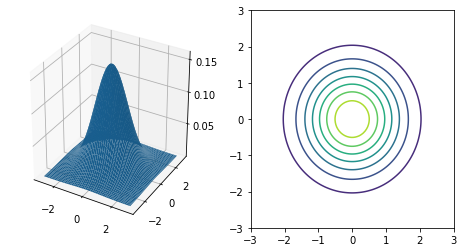

In [9]:
# Gráfico
x = np.linspace(-3, 3, 100)
y = np.linspace(-3, 3, 100)
x, y = np.meshgrid(x, y)
z = X.pdf(np.dstack([x, y]))
fig = plt.figure(figsize=(8, 4))
ax1 = fig.add_subplot(121, projection='3d')
ax1.plot_surface(x, y, z)
ax2 = fig.add_subplot(122)
ax2.contour(x, y, z)
plt.show()

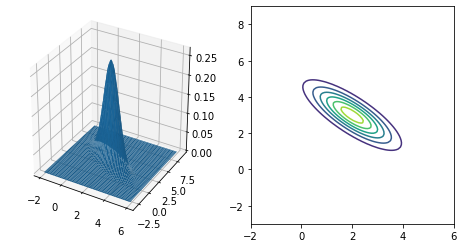

In [10]:
# Gráfico
x = np.linspace(-2, 6, 100)
y = np.linspace(-3, 9, 100)
x, y = np.meshgrid(x, y)
z = Y.pdf(np.dstack([x, y]))
fig = plt.figure(figsize=(8, 4))
ax1 = fig.add_subplot(121, projection='3d')
ax1.plot_surface(x, y, z)
ax2 = fig.add_subplot(122)
ax2.contour(x, y, z)
plt.show()

## 2. Ajuste de curvas desde una perspectiva probabilística - revisitado

Partimos de nuevo modelando la relación entre nuestra variable de salida $y$ y las variables de entrada $x$ como un **modelo lineal** con incertidumbre, la cual suponemos normal:

$$
y = \phi(x)^T w + \epsilon,
$$

con $\epsilon \sim \mathcal{N}(0, \beta^{-1})$.

Equivalentemente, podemos decir que:

$$
y \sim \mathcal{N}(\phi(x)^T w, \beta^{-1}),
$$

con lo que

$$
p(y | x, w) = \mathcal{N}(y | \phi(x)^T w, \beta^{-1}).
$$

Ya sabemos a donde nos conduce este modelo para la función de verosimilitud. 

Alternativamente, encontremos una expresión para la distribución posterior de los parámetros, usando la regla de Bayes:

\begin{align}
p(w | y, X) & = \frac{p(y, w | X)}{p(y | X)} \qquad \text{(Definición de probabilidad condicional)} \\
            & = \frac{p(y | X, w) p(w | X)}{p(y | X)} \qquad \text{(Bayes)}.
\end{align}

En este contexto, tenemos que:

- $p(w | y, X)$ es la distribución posterior de los parámetros dados los datos.

- $p(y | X, w) = \mathcal{L}(w) = \prod_{i=1}^{N} \mathcal{N}(y_i | \phi(x_i)^T w, \beta^{-1})$ es la función de verosimilitud.

- $p(y | X)$ es la distribución de evidencia.

- $p(w | X)$ es la distribución previa. Para este punto, una suposición que hace bastante sentido es que conocer únicamente las variables de entrada $X$ no nos dice absolutamente nada acerca de los parámetros $w$. Es decir, **son independientes**. Por tanto,

  $$
  p(w | X) = p(w).
  $$  

### Estimación de parámetros: MAP

Entonces, un enfoque alternativo al principio de máxima verosimilitud es estimar los parámetros con su valor **más probable**, una vez conocemos los datos, e involucrando el conocimiento previo que tengamos de los parámetros.

Esto es, maximizamos la distribución posterior:

\begin{align}
\hat{w}_{MAP} & = \arg \max_{w} p(w | y, X) \\
              & = \arg \max_{w} \frac{p(y | X, w) p(w | X)}{p(y | X)} \\
              & = \arg \max_{w} p(y | X, w) p(w | X) \qquad \text{(La distribución de evidencia no depende de $w$)} \\
              & = \arg \max_{w} \log p(y | X, w) + \log p(w) \qquad \text{(El logaritmo es una función creciente y cóncava)} \\
              & = \arg \max_{w} l(w) + \log p(w)
\end{align}

El término de log-verosimilitud ya lo conocemos:

$$
l(w) = \frac{N}{2}\log\beta - \frac{N}{2}\log(2 \pi) - \frac{\beta}{2} \left|\left|y - \Phi w\right|\right|^2,
$$

La pregunta es, **¿Qué es la distribución previa $p(w)$?**

- Este término nos permite expresar todo nuestro conocimiento previo acerca de los parámetros $w$ de una manera probabilística, es decir, a través de una distribución de probabilidad.

#### Previa normal

Una elección común es:
  
\begin{align}
p(w) & = \mathcal{N}(w | 0, \alpha^{-1} I) \\
   & = \frac{1}{\sqrt{\det(2 \pi \alpha^{-1} I)}} \exp \left\{-\frac{\alpha}{2} w^T w\right\} \\
   & = \frac{\alpha^{d / 2}}{(2 \pi)^{d / 2}} \exp \left\{-\frac{\alpha}{2} \left|\left|w\right|\right|^2\right\}. \\
\end{align}

En este caso, podemos usar el parámetro $\alpha$ para expresar cuanta certeza tenemos de que $w$ está cercano a cero.

De lo anterior, observamos que:

\begin{align}
\log p(w) & = \log \frac{\alpha^{d / 2}}{(2 \pi)^{d / 2}} -  \frac{\alpha}{2} \left|\left|w\right|\right|^2\\
\end{align}

Reemplazando en la expresión anterior y descartando todos los sumandos que no dependen de $w$:

\begin{align}
\hat{w}_{MAP} & = \arg \max_{w} l(w) + \log p(w) \\
              & = \arg \max_{w} - \frac{\beta}{2} \left|\left|y - \Phi w\right|\right|^2 - \frac{\alpha}{2} \left|\left|w\right|\right|^2 \\
              & = \arg \min_{w} \left|\left|y - \Phi w\right|\right|^2 + \underbrace{\frac{\alpha}{\beta}}_{\lambda} \left|\left|w\right|\right|^2.
\end{align}

Entonces, observamos que la estimación de parámetros por MAP, usando una previa Gaussiana nos conduce a nuestra intuición detrás de **mínimos cuadrados regularizados con norma-$2$ (Ridge)**.

#### Previa de Laplace

Otra previa común en este caso, es modelar la incertidumbre en los parámetros como una distribución de Laplace:

$$
p(w_i) = \frac{1}{2 b} \exp\left(-\frac{|w_i|}{b}\right),
$$

con lo cual, suponiendo que los parámetros son independientes:

\begin{align}
p(w) & = \prod_{i=1}^{d} p(w_i) \\
     & = \frac{1}{(2 b)^{d}} \exp\left(-\sum_{i=1}^{d}\frac{|w_i|}{b}\right) \\
     & = \frac{1}{(2 b)^{d}} \exp\left(-\frac{1}{b} \sum_{i=1}^{d}|w_i|\right). \\
\end{align}

En este caso, observamos que:

\begin{align}
\log p(w) & = \log \frac{1}{(2 b)^{d}} - \frac{1}{b} \sum_{i=1}^{d}|w_i|,\\
\end{align}

Con lo cual

\begin{align}
\hat{w}_{MAP} & = \arg \min_{w} \left|\left|y - \Phi w\right|\right|^2 + \underbrace{\frac{1}{\beta b}}_{\lambda}  \sum_{i=1}^{d}|w_i|.
\end{align}


Entonces, observamos que la estimación de parámetros por MAP, usando una previa de Laplace nos conduce a nuestra intuición detrás de **mínimos cuadrados regularizados con norma-$1$ (Lasso)**.

## 3. Conclusiones

1. Usando una perspectiva probabilística, recuperamos resultados intuitivos básicos en ajuste de curvas.

2. Vimos que los estimadores de máxima verosimilitud son propensos a overfitting si tenemos pocos datos.

3. También, vimos que los estimadores tipo MAP, al introducir la distribución previa (en la que expresamos nuestro conocimiento a priori de los parámetros), tiene un efecto de regularización.

4. Tenemos herramientas poderosas para estimar parámetros de modelos probabilísticos, sin embargo, solo estamos haciendo estimaciones puntuales de los parámetros. Una pregunta es: ¿Qué tan seguro estás de tu estimación?

<script>
  $(document).ready(function(){
    $('div.prompt').hide();
    $('div.back-to-top').hide();
    $('nav#menubar').hide();
    $('.breadcrumb').hide();
    $('.hidden-print').hide();
  });
</script>

<footer id="attribution" style="float:right; color:#808080; background:#fff;">
Created with Jupyter by Esteban Jiménez Rodríguez.
</footer>